# Binary Classifiaction with a Bank Churn Dataset using Neural Network

Note: Description

### Data Load

### EDA

### Feature Engineering

### Machine Learning Model

### Model Training

### Model Evaluation

   id  CustomerId         Surname  CreditScore Geography Gender   Age  Tenure  \
0   0    15674932  Okwudilichukwu          668    France   Male  33.0       3   
1   1    15749177   Okwudiliolisa          627    France   Male  33.0       1   
2   2    15694510           Hsueh          678    France   Male  40.0      10   
3   3    15741417             Kao          581    France   Male  34.0       2   
4   4    15766172       Chiemenam          716     Spain   Male  33.0       5   

     Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  \
0       0.00              2        1.0             0.0        181449.97   
1       0.00              2        1.0             1.0         49503.50   
2       0.00              2        1.0             0.0        184866.69   
3  148882.54              1        1.0             1.0         84560.88   
4       0.00              2        1.0             1.0         15068.83   

   Exited  
0       0  
1       0  
2       0  
3       0  
4 

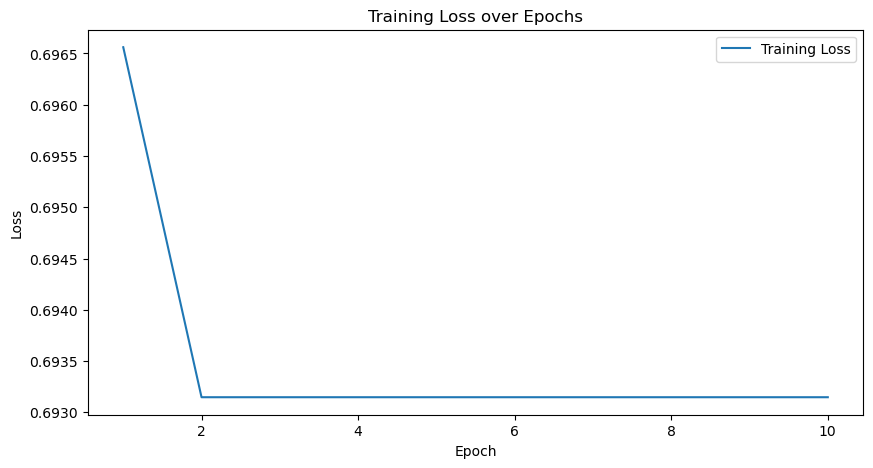

In [3]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Load the data
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

# Display the first few rows of the train dataset
print(df_train.head())

# Check data for missing values
missing_values = df_train.isnull().sum()
print(missing_values)

# Define columns
categorical_columns = ['Geography', 'Gender']
numerical_columns = ['CreditScore', 'Tenure', 'Balance', 'EstimatedSalary']

# Preprocessing
processor = ColumnTransformer([
    ('OHE', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_columns),
    ('STD_SCL', StandardScaler(), numerical_columns)
], remainder='passthrough')

# Preprocess the train data
X_train = df_train.drop(['Exited', 'CustomerId', 'Surname', 'id'], axis=1)
y_train = df_train['Exited']

X_train_processed = processor.fit_transform(X_train)
y_train_numpy = y_train.values.astype(np.float32)

# Preprocess the test data
X_test = df_test.drop(['CustomerId', 'Surname', 'id'], axis=1)
X_test_processed = processor.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_processed, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_numpy, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32)

# Define the neural network model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)   
        self.fc2 = nn.Linear(64, 128)          
        self.fc3 = nn.Linear(128, 64)          
        self.fc4 = nn.Linear(64, 32)           
        self.fc5 = nn.Linear(32, 16)           
        self.fc6 = nn.Linear(16, 1)            
        self.activation = nn.ReLU()           
        self.sigmoid = nn.Sigmoid()            

    def forward(self, x):
        x = self.activation(self.fc1(x))       
        x = self.activation(self.fc2(x))       
        x = self.activation(self.fc3(x))       
        x = self.activation(self.fc4(x))       
        x = self.activation(self.fc5(x))       
        x = self.sigmoid(self.fc6(x))         
        return x

# Initialize the model
input_size = X_train_tensor.shape[1]
model = NeuralNetwork(input_size)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  
optimizer = optim.Adam(model.parameters(), lr=0.001)  

# Create data loader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Training the model
num_epochs = 10
train_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}")

# Calculate accuracy after training
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_predictions = torch.round(torch.sigmoid(test_outputs)).int()
    test_accuracy = (test_predictions == y_train_tensor).float().mean().item()
    print(f"Test Accuracy after Training: {test_accuracy:.2%}")

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()
